In [1]:
import json
from tqdm import tqdm 

import torch
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from datasets import get_MNIST, postprocess
from model import Glow
from attacks import PGD

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda")
output_folder = 'output/'
model_name = 'glow_checkpoint_9800.pt'

with open(output_folder + 'hparams.json') as json_file:  
    hparams = json.load(json_file)

In [3]:
_, test_mnist = get_MNIST(hparams['num_classes'])

model = Glow(
    hparams['img_shape'], 
    hparams['hidden_channels'], 
    hparams['K'], 
    hparams['L'], 
    hparams['actnorm_scale'],
    hparams['flow_permutation'], 
    hparams['flow_coupling'], 
    hparams['LU_decomposed'], 
    hparams['num_classes'],
    hparams['learn_top'], 
    hparams['y_condition']
)

model.load_state_dict(torch.load(output_folder + model_name)['model'])
model.set_actnorm_init()
model = model.to(device)
model = model.eval()

In [4]:
def sample(model, n_samples=4):
    with torch.no_grad():
        if hparams['y_condition']:
            y = torch.zeros(hparams['num_classes']*n_samples, hparams['num_classes']).to(device)
            for i in range(hparams['num_classes']):
                y[n_samples*i: n_samples*(i+1), i] = 1.
        else: y = None
        images = postprocess(model(y_onehot=y, temperature=0.7, reverse=True))
    return images.cpu()

In [6]:
n_samples = 12
images = sample(model, n_samples)
grid = make_grid(images, nrow=n_samples).permute(1, 2, 0)

plt.figure(figsize=(14, 14))
plt.imshow(grid)
plt.axis('off')
plt.title("Class-conditional generated examples", fontsize=26)
plt.show()

In [8]:
adv_eps = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
M = [2, 4, 8, 16, 32, 64]

testloader = DataLoader(
    test_mnist,
    batch_size=100,
    shuffle=False,
    num_workers=1,
    drop_last=False
)

x, y = next(iter(testloader))
x = x.to(device)
y = y.to(device)

adv_examples = []
accuracy = []
results = {}

for m in M:
    results[str(m)] = {}
    for eps in adv_eps:
        attack = PGD(
            model, 
            eps=eps, 
            alpha=eps/8,
            steps=10,
            num_mc_samples=m,
            num_classes=hparams['num_classes'],
        )

        adv_img = attack(x, y)
        out = attack.get_mse(adv_img)
        pred = torch.argmin(out, dim=1).detach().cpu()
        correct = pred.eq(torch.argmax(y.detach().cpu(), dim=1).view_as(pred)).sum().item()
        acc = correct / 100

        results[str(m)][str(eps)] = {
            'adv_img': adv_img.detach().cpu(),
            'accuracy': acc
        }

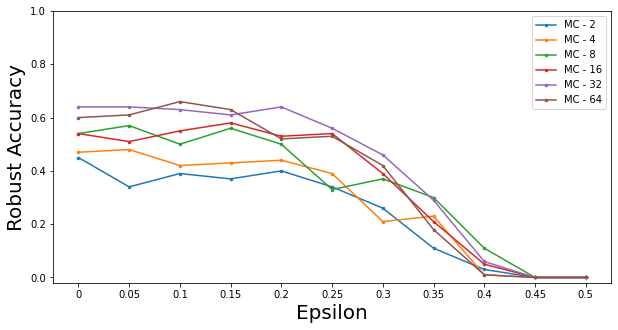

In [9]:
plt.figure(figsize=(10, 5))

for m in M:
    accs = [results[str(m)][str(eps)]['accuracy'] for eps in adv_eps]
    plt.plot(accs, marker='.', label=f"MC - {m}", markersize=5)

plt.xticks(range(len(accs)), adv_eps)
plt.xlabel("Epsilon", fontsize=20)
plt.ylabel("Robust Accuracy", fontsize=20)
plt.ylim([-0.02, 1])
plt.legend()
plt.show()

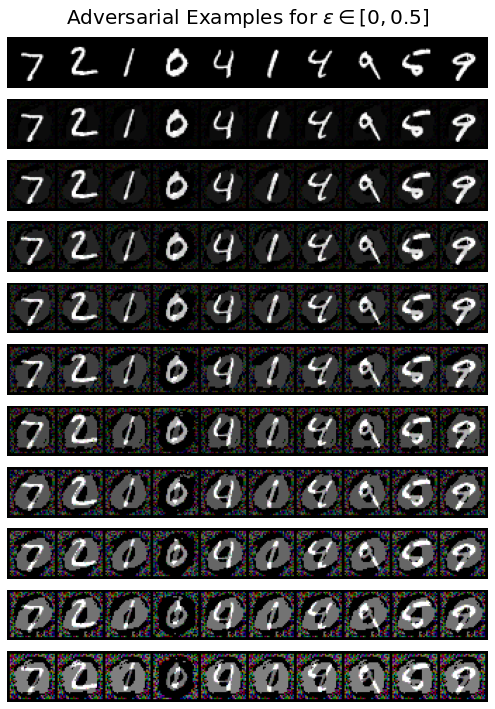

In [10]:
fig, axs = plt.subplots(len(adv_eps), 1, figsize=(10, 10))

for ax, eps in zip(axs, adv_eps):
    img = results[str(M[-1])][str(eps)]['adv_img'][:10]
    g = make_grid(postprocess(img), nrow=10).permute(1, 2, 0)
    ax.imshow(g)
    ax.axis('off')

plt.suptitle("Adversarial Examples for $\epsilon \in [0, 0.5]$", fontsize=20)
plt.tight_layout()
plt.show()